In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import helper

ticker = ['MSFT', 'VOO']  # first is the stock, second is the reference (benchmark)
past = '3y'  # 3 years of historical data

df = helper.read_ticker(ticker, past)

timeframes = [21, 63, 252]  # 1 month, 3 months, 1 year
for timeframe in timeframes:
  for t in ticker:
    df[f'Ann.Vol_{t}_{timeframe}'] = helper.annualized_vol(df[f'{t}_Close'], window=timeframe)

df['FED_rate'], df['ECB_rate'] = helper.read_risk_free()
df.dropna(inplace=True)  # FED rate missing for latest day, ignore it
for t in ticker:
  df[f'{t}_Returns'] = np.log(df[f'{t}_Close'] / df[f'{t}_Close'].shift(1)).fillna(0)

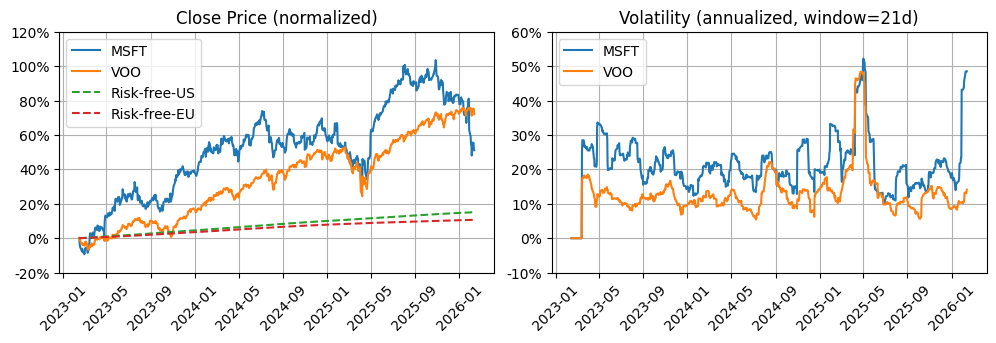

In [9]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))
fig.tight_layout()
for t in ticker:
  ax1.plot((df[f'{t}_Close'] - df[f'{t}_Close'].iloc[0]) / df[f'{t}_Close'].iloc[0], label=t)
ax1.plot(df.index, (1 + df['FED_rate'] / 100 / 252).cumprod() - 1, ls='--', label='Risk-free-US')
ax1.plot(df.index, (1 + df['ECB_rate'] / 100 / 252).cumprod() - 1, ls='--', label='Risk-free-EU')
ax1.tick_params(axis='x', rotation=45)
ax1.set_title('Close Price (normalized)')
ax1.set_yticks(ax1.get_yticks())
ax1.set_yticklabels([f'{y * 100:.0f}%' for y in ax1.get_yticks()])
ax1.legend()
ax1.grid()

timeframe = timeframes[0]
for t in ticker:
  ax2.plot(df[f'Ann.Vol_{t}_{timeframe}'], label=t)
ax2.tick_params(axis='x', rotation=45)
ax2.set_title(f'Volatility (annualized, window={timeframe}d)')
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([f'{y * 100:.0f}%' for y in ax2.get_yticks()])
ax2.legend()
ax2.grid()
plt.show()

In [10]:
for t in ticker:
  print(f'Raw sharpe ratio {t}: {helper.annualized_return(df[f"{t}_Close"]) / helper.annualized_vol(df[f"{t}_Close"], window=timeframe).iloc[-1]:.3f}')

for t in ticker:
  print(f'Sharpe ratio {t}: {helper.sharpe_ratio(df[f"{t}_Returns"], df["FED_rate"]):.3f}')

beta, alpha = helper.risk_params(df, ticker[0], ticker[1], df['FED_rate'])
print(f'Risk parameters of {ticker[0]} vs {ticker[1]}:')
print(f'Beta: {beta:.4f}\tAlpha: {alpha:.4f}')

Raw sharpe ratio MSFT: 0.308
Raw sharpe ratio VOO: 1.423
Sharpe ratio MSFT: 0.387
Sharpe ratio VOO: 0.917
Risk parameters of MSFT vs VOO:
Beta: 1.0281	Alpha: -0.0559
